In [1]:
using Revise
using Turing, MCMCChains
using XLSX
using DataFrames, TimeSeries
using StatsPlots
using Plots
using LinearAlgebra
using CSV
using StatsBase
include("../utils.jl")
include("../financial_bvar_temp.jl")
using .FinancialBVAR

In [23]:
df = DataFrame(XLSX.readtable("../data/usa_var_data.xlsx", "Data", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :Date), Dates.quarter, last)

292×11 TimeArray{Float64, 2, Date, Matrix{Float64}} 1951-12-01 to 2024-07-01
┌────────────┬──────────┬───────────┬─────────────┬──────────┬────────┬─────────
│            │ Yeld_10Y │ Price_10Y │ Stock_Price │ Dividend │ E      │ CAPE   ⋯
├────────────┼──────────┼───────────┼─────────────┼──────────┼────────┼─────────
│ 1951-12-01 │  0.02513 │   104.098 │       24.19 │  1.41333 │   2.44 │ 12.527 ⋯
│ 1952-03-01 │  0.02505 │   104.824 │       23.74 │     1.43 │    2.4 │ 12.242 ⋯
│ 1952-06-01 │  0.02415 │   106.295 │       25.08 │     1.45 │   2.34 │ 12.669 ⋯
│ 1952-09-01 │  0.02685 │   104.468 │       24.26 │  1.43667 │   2.36 │ 12.131 ⋯
│ 1952-12-01 │  0.02547 │   106.402 │       26.18 │     1.41 │    2.4 │ 13.010 ⋯
│ 1953-03-01 │  0.02735 │   105.373 │       24.71 │  1.41333 │   2.43 │ 12.163 ⋯
│ 1953-06-01 │  0.02987 │    103.86 │       24.29 │     1.42 │   2.51 │ 11.750 ⋯
│ 1953-09-01 │  0.02636 │    107.81 │       23.97 │     1.43 │   2.55 │ 11.391 ⋯
│     ⋮      │    ⋮     │     ⋮ 

In [25]:
freq = 4
returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
returns = merge(returns, log1p.(data_source[:T_Bill])./freq)
cpi = percentchange(data_source[:CPI], :log)
real_returns = returns .- cpi
term = data_source[:Yeld_10Y] ./freq .- data_source[:T_Bill] ./freq
dy = data_source[:Dividend_Yeld] #log.(data_source[:Dividend_Yeld])
data = merge(real_returns, dy, term, cpi)

291×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1952-03-01 to 2024-07-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 1952-03-01 │      1.98335e-5 │     0.0107337 │  0.00772445 │     0.0602359 │ ⋯
│ 1952-06-01 │       0.0581411 │    0.00263202 │ -0.00708528 │      0.057815 │ ⋯
│ 1952-09-01 │      -0.0185027 │    -0.0173351 │  0.00423886 │     0.0592197 │ ⋯
│ 1952-12-01 │       0.0932838 │     0.0220972 │   0.0089235 │     0.0538579 │ ⋯
│ 1953-03-01 │      -0.0437093 │   -0.00972202 │  0.00497517 │     0.0571967 │ ⋯
│ 1953-06-01 │      -0.0100139 │    -0.0219485 │ -0.00227055 │     0.0584603 │ ⋯
│ 1953-09-01 │     -0.00574595 │     0.0298874 │ -0.00299956 │     0.0596579 │ ⋯
│ 1953-12-01 │        0.078226 │     0.0248173 │  0.00767892 │     0.0572141 │ ⋯
│     ⋮      │        ⋮        │ 

In [85]:
start = Date(1993,03,01)
end_d = Date(2019, 12, 31)
s_data = to(from(data, start),end_d)
returns_summarystats(to(from(returns, start),end_d), 4)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.1397,0.7827,0.0941,0.252,-1.0147,-0.887,-0.0155,0.151,2.3288,0.6736,0.1398
Price_10Y,0.0792,0.5691,0.0544,0.1676,-0.2868,0.4219,-0.0613,0.019,0.3079,0.6869,0.0386
T_Bill,0.01,0.0583,0.0234,0.0451,0.0001,0.2594,0.002,0.9802,-1.4856,2.3432,0.0186


In [86]:
returns_summarystats(s_data, 1)
display("Annulaised data")
returns_summarystats(s_data, 4)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_CPI,0.0694,0.1938,0.018,0.0604,-0.2381,-0.7223,-0.011,0.1286,1.788,0.2598,0.0258
Price_10Y_CPI,0.0421,0.1677,0.0081,0.0367,-0.0763,0.5554,-0.0231,0.0139,0.9504,0.1923,0.0052
T_Bill_CPI,0.008,0.0255,0.0004,0.0053,-0.0208,0.0432,-0.0045,0.1313,0.4541,0.0446,0.001
Dividend_Yeld,0.0044,0.0324,0.0194,0.021,0.0113,0.6411,0.0173,0.9253,0.5839,4.3793,0.0191
Yeld_10Y_T_Bill,0.0027,0.0095,0.0043,0.0066,-0.0016,-0.113,0.0023,0.8801,-0.9337,1.5638,0.0044
CPI,0.0073,0.0236,0.0055,0.0096,-0.0254,-0.7445,0.0023,-0.0878,3.1538,0.7553,0.0052


"Annulaised data"

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_CPI,0.1388,0.7753,0.0721,0.2417,-0.9526,-0.7223,-0.0441,0.1286,1.788,0.5196,0.103
Price_10Y_CPI,0.0843,0.6707,0.0324,0.1468,-0.3051,0.5554,-0.0925,0.0139,0.9504,0.3847,0.0208
T_Bill_CPI,0.0161,0.1019,0.0014,0.0211,-0.0832,0.0432,-0.0182,0.1313,0.4541,0.0893,0.0038
Dividend_Yeld,0.0089,0.1295,0.0775,0.0842,0.045,0.6411,0.069,0.9253,0.5839,8.7587,0.0764
Yeld_10Y_T_Bill,0.0055,0.038,0.0172,0.0262,-0.0065,-0.113,0.0091,0.8801,-0.9337,3.1277,0.0177
CPI,0.0145,0.0946,0.022,0.0386,-0.1016,-0.7445,0.0093,-0.0878,3.1538,1.5105,0.0208


In [87]:
#returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
returns1y = from(to(percentchange(collapse(data_source[:Total_Stock, :Price_10Y],year, last), :log),end_d),start)
returns_summarystats(returns1y,1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.1739,0.302,0.0941,0.2346,-0.4393,-1.2372,-0.0013,0.0538,1.5035,0.5411,0.1263
Price_10Y,0.086,0.2266,0.0544,0.1172,-0.1063,-0.0647,0.0023,-0.4625,-0.6256,0.6323,0.044


In [88]:
returns1y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],4) ./1
returns3y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],12) ./3
returns5y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],20) ./5
returns10y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],40) ./10
cum_returns = merge(TimeSeries.rename!(returns1y, [:RealStock1y, :RealBonds1y, :RealTBill1y]), 
                    TimeSeries.rename!(returns3y, [:RealStock3y, :RealBonds3y, :RealTBill3y]), 
                    TimeSeries.rename!(returns5y, [:RealStock5y, :RealBonds5y, :RealTBill5y]),
                    TimeSeries.rename!(returns10y, [:RealStock10y, :RealBonds10y, :RealTBill10y]))
returns_summarystats(expm1.(cum_returns),1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
RealStock1y,0.1506,0.4114,0.0778,0.1633,-0.3789,-1.1856,0.0331,0.7221,1.8079,0.5162,0.0994
RealBonds1y,0.0704,0.2037,0.0257,0.0711,-0.1238,0.1018,-0.0205,0.5665,-0.5398,0.365,0.0211
RealTBill1y,0.0139,0.0315,-0.0081,-0.0014,-0.034,0.8559,-0.0159,0.76,0.7803,-0.5855,-0.0103
RealStock3y,0.0913,0.1757,0.0522,0.1139,-0.1598,-0.8141,-0.0115,0.9044,-0.5492,0.5717,0.0925
RealBonds3y,0.0327,0.0981,0.0258,0.0453,-0.0339,0.3926,0.0003,0.7422,-0.7292,0.7887,0.0199
RealTBill3y,0.0088,0.0115,-0.0074,-0.0021,-0.0241,0.3323,-0.0121,0.8948,-0.4959,-0.8441,-0.0089
RealStock5y,0.071,0.1695,0.0433,0.1124,-0.0611,0.1214,-0.0191,0.9387,-1.4871,0.6095,0.0343
RealBonds5y,0.0204,0.0702,0.028,0.0417,-0.009,-0.0063,0.0132,0.7729,-0.9709,1.3728,0.0294
RealTBill5y,0.0081,0.0156,-0.0058,-0.0006,-0.0201,0.4145,-0.0117,0.9129,-0.3356,-0.7209,-0.006
RealStock10y,0.0429,0.1331,0.0469,0.0722,-0.0516,-0.4738,0.025,0.9524,-0.1249,1.095,0.0548


In [89]:
round.(percentile(values(returns10y)[:,1], [5, 25, 50, 75, 95]), digits=4)

5-element Vector{Float64}:
 -0.0338
  0.0247
  0.0533
  0.0697
  0.1102

In [90]:
returns5y = moving(sum,returns[:Total_Stock, :Price_10Y, :T_Bill],15) ./ 5
percentile(values(returns5y)[:,1], [5, 25, 50, 75, 95]) .- 0.03

5-element Vector{Float64}:
 -0.05631638546077937
  0.0197682257575379
  0.055492855172298836
  0.07854526853104804
  0.13150548844326004

In [91]:
percentile(values(returns5y)[:,2], [5, 25, 50, 75, 95]) .- 0.03

5-element Vector{Float64}:
 -0.03182677373411721
 -0.013964106739768951
  0.00831352848251015
  0.02658206783196622
  0.07235629688679483

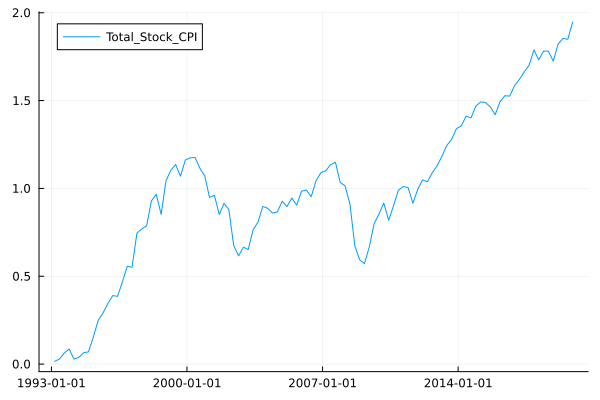

In [92]:
plot(cumsum(s_data[:Total_Stock_CPI]))

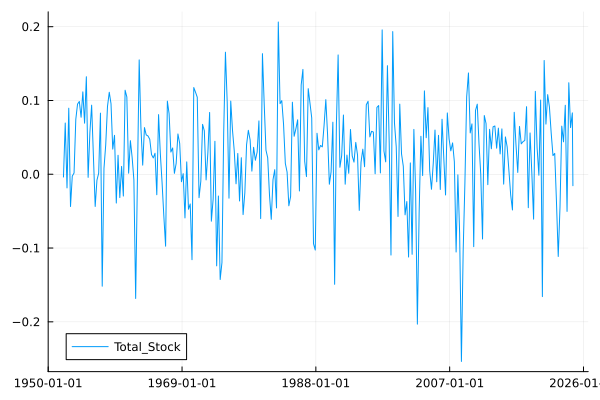

In [93]:
plot(returns[:Total_Stock])

In [94]:
cape = collapse(data_source[:CAPE], Dates.quarter, last)
Δcape = percentchange(cape, :log)
adj_returns = returns[:Total_Stock] .- Δcape
returns_summarystats(merge(returns[:Total_Stock], adj_returns, Δcape),4)


,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.1368,0.8255,0.1042,0.2741,-1.0147,-0.6199,-0.0406,0.1422,1.2115,0.7619,0.1269
Total_Stock_CAPE,0.0235,0.2429,0.0901,0.1166,-0.1095,0.0858,0.0628,0.6842,1.2777,3.8333,0.0854
CAPE,0.1412,0.7461,0.0142,0.2052,-0.9743,-0.4754,-0.1406,0.165,0.6997,0.1002,0.0361


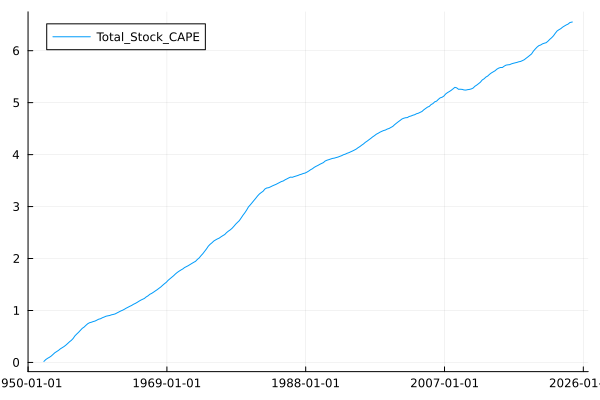

In [95]:
plot(cumsum(adj_returns))


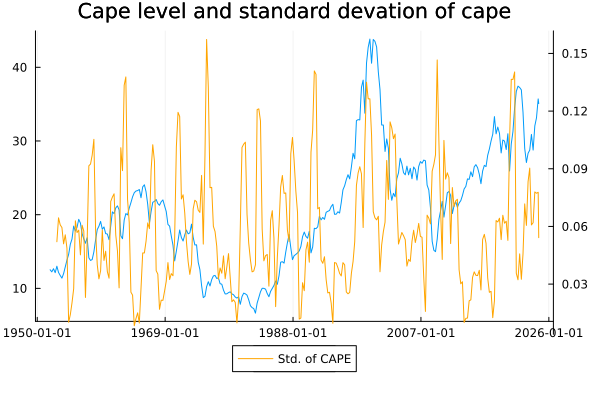

In [96]:
stdcape = moving(std,Δcape, 4)
plot(cape, label="CAPE")
plot!(twinx(),stdcape, color=:orange, label="Std. of CAPE")
plot!(legend=:outerbottom)
title!("Cape level and standard devation of cape")

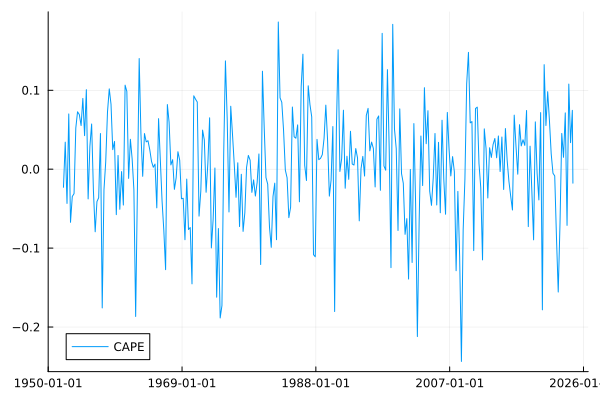

In [97]:
plot(Δcape)

In [98]:
r = returns[:Total_Stock]
sqrt(mean((values(r) .-  mean(values(r))) .^ 2))

0.06828153958153331

In [99]:
sqrt(mean((values(r) .-  mean(values(adj_returns))) .^ 2))

0.06837317748891925

In [100]:
std(values(returns[:Total_Stock]))

0.06839916505990531

In [101]:
std(values(returns[:Total_Stock]), mean=mean(values(adj_returns)))

0.06849096082771383

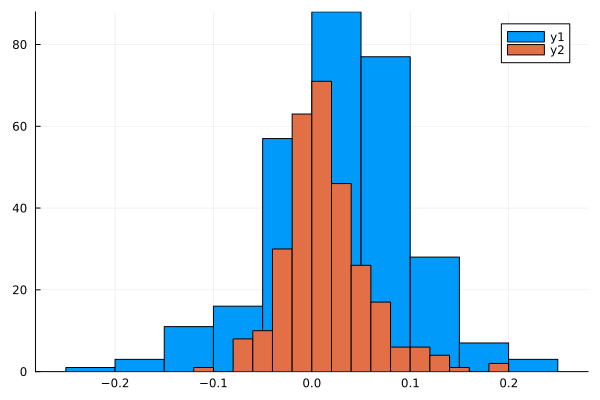

In [102]:
histogram(expm1.(values(returns[:Total_Stock]) ))
histogram!(expm1.(values(returns[:Price_10Y]) ))

In [103]:
returns_summarystats(data_source[:Yeld_10Y],1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Yeld_10Y,0.0292,0.1584,0.0548,0.0736,0.0066,0.9377,0.0333,0.9774,0.6945,1.8772,0.0468
